# Traffic sign classification



# Transfer Learning

transfer learning the process of reusing the model trained for anothor task.there are two approaches to perform transfer learning .

1.feature Extraction
2.fine tuning

In [1]:
import os # work with directory
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
img_size = 224
from keras.utils import to_categorical

In [2]:
print(os.listdir("/kaggle/input/belgiumts-dataset/BelgiumTSC_Training/Training"))
print(os.listdir("/kaggle/input/belgiumts-dataset/BelgiumTSC_Testing/Testing"))

['00021', '00010', '00041', '00020', '00019', '00024', '00030', '00027', '00013', '00015', '00029', '00034', '00014', '00012', '00017', '00011', '00060', '00032', '00000', '00051', '00036', '00045', '00026', '00025', '00002', '00059', '00044', '00022', '00046', '00031', '00006', '00049', '00008', '00040', '00009', '00048', '00053', '00061', '00005', '00001', '00037', '00052', '00058', 'Readme.txt', '00016', '00004', '00028', '00055', '00050', '00023', '00038', '00056', '00003', '00047', '00054', '00035', '00018', '00042', '00043', '00057', '00007', '00033', '00039']
['00021', '00010', '00041', '00020', '00019', '00024', '00030', '00027', '00013', '00015', '00029', '00034', '00014', '00012', '00017', '00011', '00060', '00032', '00000', '00051', '00036', '00045', '00026', '00025', '00002', '00059', '00044', '00022', '00046', '00031', '00006', '00049', '00008', '00040', '00009', '00048', '00053', '00061', '00005', '00001', '00037', '00052', '00058', 'Readme.txt', '00016', '00004', '00028'

load_dataset method which will be used for loading the traning dataset as well as testing dataset.

In [3]:
def load_dataset(file_name):
    if file_name == "Training":
        directory = "/kaggle/input/belgiumts-dataset/BelgiumTSC_Training/Training"
    elif file_name =="Testing":
        directory = "/kaggle/input/belgiumts-dataset/BelgiumTSC_Testing/Testing"
        
    list_images =[]
    list_labels=[]
    
    count = 0
        
    for sub_dir in tqdm(os.listdir(directory)):

        
        if sub_dir == 'Readme.txt':
            pass
        
        else:
            inner_directory = os.path.join(directory,sub_dir)
            for image_file in os.listdir(inner_directory):
                
                if image_file.endswith(".ppm"):
                    
                    img = cv2.imread(os.path.join(inner_directory,image_file))
                    img = cv2.resize(img,(img_size,img_size))
                    
                    list_images.append(img)
                    
                    list_labels.append(count)
            count +=1   
            
    list_images = np.array(list_images).reshape(-1,img_size,img_size,3)        
                    
    list_labels = np.array(list_labels)
    list_labels= to_categorical(list_labels,count)        
  
      
    return list_images , list_labels              
                    
                    
                    
                    
            
            
            

**training_dadaset contain image features which will be used to train the model and training_label contain outputs.**

In [4]:
training_dataset , training_label =load_dataset("Training")
testing_dataset , testing_label =load_dataset("Testing")


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


# Now training dataset is devided into two part .

1.training_set
2.validation_set

training_set is used to train the model and validation dataset is used to ckeck whether overfiting problem is occur or not.

overfitting problem --> when our model give more correctly result on training set but not give correct result on validation set then we can say that there is overfitting problem.



In [5]:
from sklearn.model_selection import train_test_split
X_train,X_val, Y_train, Y_val = train_test_split(training_dataset,training_label ,test_size=0.2, random_state=101,shuffle = True)

# 1. I am using second type of transfer learning --> finetuning

a. i will use pretrained VGG-16 model .and remove last layer (output layer) from vgg-16.i will add some dense layer and only train these dense layer .
b. all vgg-16 model will remain freeze.

In [6]:
from keras.layers import Input ,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam


In [7]:
vgg = VGG16(input_shape = [img_size,img_size,3],weights='imagenet',include_top = False) # include_top = false means remove output layer


58892288/58889256 [==============================] - 1s 0us/step


In [8]:
for layer in vgg.layers:
    layer.trainable = False

In [9]:
X = Flatten()(vgg.output)

layer1 = Dense(512,activation = "relu")(X)

layer2 = Dense(1536,activation = "relu")(layer1)

layer3 = Dense(3072,activation = "relu")(layer2)

layer4 = Dense(6144,activation = "relu")(layer3)

layer5 = Dense(12288,activation = "relu")(layer4)

prediction = Dense(Y_train.shape[1],activation = "softmax")(layer5) # output layer 

above these two layers are added with vgg16 model .but only these two layer are used to train.

In [10]:
# create the model object

model = Model(inputs = vgg.input,outputs = prediction)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
opt = Adam(learning_rate=0.0001)
model.compile(loss = "categorical_crossentropy",optimizer=opt,metrics =['accuracy'])

In [13]:
ans = model.fit(X_train ,Y_train , batch_size = 16,epochs =30,validation_data=(X_val,Y_val))

Epoch 1/30
229/229 [==============================] - 16s 71ms/step - loss: 1.3456 - accuracy: 0.7339 - val_loss: 0.5074 - val_accuracy: 0.8787
Epoch 2/30
229/229 [==============================] - 15s 67ms/step - loss: 0.1801 - accuracy: 0.9587 - val_loss: 0.4138 - val_accuracy: 0.9311
Epoch 3/30
229/229 [==============================] - 15s 67ms/step - loss: 0.0741 - accuracy: 0.9842 - val_loss: 0.3146 - val_accuracy: 0.9268
Epoch 4/30
229/229 [==============================] - 15s 66ms/step - loss: 0.1103 - accuracy: 0.9795 - val_loss: 0.1574 - val_accuracy: 0.9639
Epoch 5/30
229/229 [==============================] - 15s 66ms/step - loss: 0.0251 - accuracy: 0.9937 - val_loss: 0.3114 - val_accuracy: 0.9628
Epoch 6/30
229/229 [==============================] - 15s 67ms/step - loss: 0.0865 - accuracy: 0.9836 - val_loss: 0.1685 - val_accuracy: 0.9563
Epoch 7/30
229/229 [==============================] - 15s 67ms/step - loss: 0.0273 - accuracy: 0.9943 - val_loss: 0.4910 - val_accuracy:

now we can see it gave 100% accuracy .

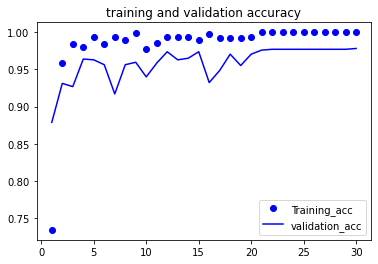

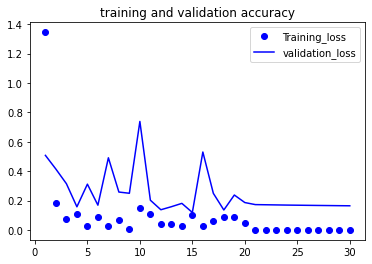

In [14]:
acc = ans.history['accuracy']
val_acc = ans.history['val_accuracy']
loss = ans.history['loss']
val_loss = ans.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label ='Training_acc')
plt.plot(epochs,val_acc,'b',label ='validation_acc')
plt.title("training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label ='Training_loss')
plt.plot(epochs,val_loss,'b',label ='validation_loss')
plt.title("training and validation accuracy")
plt.legend()

plt.show()

In [15]:
predict = np.argmax(model.predict(testing_dataset), axis = 1)
count = 0
for i in range(0,predict.shape[0]):
    if (predict[i] == np.argmax(testing_label[i])):
        count +=1
print ('Accuracy on Test ',100 * count/predict.shape[0],'%')

Accuracy on Test  91.94444444444444 %
